In [1]:
from fetching.missy_fetching import get_vertretungen
import os
from dotenv import load_dotenv
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from config import update_cache
from fetching.missy_fetching import get_distances, get_clients, get_mas, get_prio_assignments
from fetching.experience_logging import get_experience_log

from data_processing.data_processor import DataProcessor
from optimize.optimize import Optimizer
from learning.model import AbnormalityModel
from data_processing.features_retrieval.create_single_df import create_single_df
from data_processing.features_retrieval.create_replacements import create_replacements
load_dotenv(override=True)

user = os.getenv("USER")
pw = os.getenv("PASSWORD")

c:\Users\Valentin\Desktop\TALÖVSIS\Code\AI-Schnittstelle\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Retrieve mostly static data
distances = get_distances(user, pw, update_cache=update_cache)
clients = get_clients(user, pw, update_cache=update_cache)
mas = get_mas(user, pw, update_cache=update_cache)
prio_assignments = get_prio_assignments(user, pw, update_cache=update_cache)
experience_log = get_experience_log()

In [7]:
def create_comparison_plots(my_dict):
    # Get all keys that end with '_labels' or '_recommendations'
    keys = [k.replace('_labels', '') for k in my_dict.keys() if k.endswith('_labels') and isinstance(my_dict[k], dict)]
    
    print(keys)
    
    # Create a figure with subplots
    n_keys = int(len(keys) / 2) + 1
    fig, axes = plt.subplots(n_keys, 2, figsize=(10, 5*n_keys))
    if n_keys == 1:
        axes = [axes]
        
    print(my_dict["count_labels"])
    print(my_dict["timeToSchool_labels"])
    print(my_dict["timeToSchool_labels"]["min"])
    
    # Create box plots for each key
    for idx, key in enumerate(keys):
        # Prepare data for box plot
        labels_data = [
            my_dict[f"{key}_labels"]["min"],
            my_dict[f"{key}_labels"]["mean"],
            my_dict[f"{key}_labels"]["median"],
            my_dict[f"{key}_labels"]["max"]
        ]
        
        recommendations_data = [
            my_dict[f"{key}_recommendations"]["min"],
            my_dict[f"{key}_recommendations"]["mean"],
            my_dict[f"{key}_recommendations"]["median"],
            my_dict[f"{key}_recommendations"]["max"]
        ]
        
        # Create box plot
        data = [labels_data, recommendations_data]
        d_index = int(idx / 2), idx % 2
        sns.boxplot(data=data, ax=axes[d_index])
        axes[d_index].set_title(f'Comparison of {key}')
        axes[d_index].set_ylabel('Value')
    
    plt.tight_layout()
    plt.show()


In [11]:

def create_time_series_plots(comparison):
    # Get all keys that end with '_labels' or '_recommendations'
    keys = [k.replace('_labels', '') for k in comparison[0].keys() 
            if k.endswith('_labels') and isinstance(comparison[0][k], dict)]
    
    # Create a figure with subplots
    n_keys = int(len(keys) / 2) + 1
    fig, axes = plt.subplots(n_keys, 2, figsize=(12, 5*n_keys))
    if len(keys) == 1:
        axes = [axes]
    
    # Sort comparison by date
    comparison.sort(key=lambda x: x['date'])
    dates = [entry['date'] for entry in comparison]
    
    # Create line plots for each key
    for idx, key in enumerate(keys):
        d_index = int(idx / 2), idx % 2
        # Extract means for labels and recommendations
        labels_means = [entry[f"{key}_labels"]["mean"] for entry in comparison]
        recommendations_means = [entry[f"{key}_recommendations"]["mean"] for entry in comparison]
        
        # Create line plot
        axes[d_index].plot(dates, labels_means, 'b-', label='Labels', marker='o')
        axes[d_index].plot(dates, recommendations_means, 'r-', label='Recommendations', marker='s')
        
        # Customize plot
        axes[d_index].set_title(f'Time Series of {key} Means')
        axes[d_index].set_xlabel('Date')
        axes[d_index].set_ylabel('Mean Value')
        axes[d_index].legend()
        axes[d_index].grid(True)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[d_index].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


In [9]:
data_processor = DataProcessor(
    mas, clients, prio_assignments, distances, experience_log
)
comparison = []
start_date = "2025-03-01"
end_date = "2025-03-31"
for relevant_date in pd.date_range(start=start_date, end=end_date):
    relevant_date = relevant_date.strftime("%Y-%m-%d")

    vertretungen = get_vertretungen(
        relevant_date, user, pw, use_cache=False, update_cache=False
    )

    if len(vertretungen) == 0:
        continue

    relevant_date = datetime.strptime(relevant_date, "%Y-%m-%d")

    free_ma_records = list(
        filter(lambda x: x.get("mavertretend") != None, vertretungen)
    )
    open_client_records = list(
        filter(lambda x: x.get("klientzubegleiten") != None, vertretungen)
    )

    free_ma_ids = [elem["mavertretend"]["id"] for elem in free_ma_records]
    open_client_ids = [
        elem["klientzubegleiten"]["id"] for elem in open_client_records
    ]
    assignments = [
        {
            "ma": elem["mavertretend"]["id"],
            "klient": elem["klientzubegleiten"]["id"],
        }
        for elem in vertretungen
        if elem.get("mavertretend") != None
        and elem.get("klientzubegleiten") != None
    ]

    clients_df, mas_df = data_processor.create_day_dataset(
        open_client_ids, free_ma_ids, relevant_date
    )

    abnormality_model = AbnormalityModel()

    optimizer = Optimizer(mas_df, clients_df, abnormality_model)
    optimizer.create_model()

    optimizer.solve_model()
    assigned_pairs, recommendation_id = optimizer.process_results()

    assigned_pairs = {elem["ma"]: elem["klient"] for elem in assigned_pairs}
    assignments = {elem["ma"]: elem["klient"] for elem in assignments}

    replacements = create_replacements(assignments)
    replacement_recommendations = create_replacements(assigned_pairs)

    single_df_labels = create_single_df(
        clients_df, mas_df, replacements, relevant_date
    )
    single_df_recommendations = create_single_df(
        clients_df, mas_df, replacement_recommendations, relevant_date
    )

    # print(f"Labels: {single_df_labels.describe()}")
    # print(f"Recommendations: {single_df_recommendations.describe()}")

    # Create a dictionary that retrieves entries from the describe function
    description_labels = single_df_labels.describe().to_dict()
    description_recommendations = single_df_recommendations.describe().to_dict()

    my_dict = {
        "date": relevant_date,
        "count_labels": len(single_df_labels),
        "count_recommendations": len(single_df_recommendations),
    }

    # Loop through all keys in the description dictionaries
    for key in description_labels.keys():
        if key == "date":
            continue
        my_dict[f"{key}_labels"] = {
            "mean": description_labels[key]["mean"],
            "median": description_labels[key]["50%"],
            "std": description_labels[key]["std"],
            "min": description_labels[key]["min"],
            "max": description_labels[key]["max"],
        }
        my_dict[f"{key}_recommendations"] = {
            "mean": description_recommendations[key]["mean"],
            "median": description_recommendations[key]["50%"],
            "std": description_recommendations[key]["std"],
            "min": description_recommendations[key]["min"],
            "max": description_recommendations[key]["max"],
        }

    comparison.append(my_dict)


learner_dataset:  {(0, 0): {'timeToSchool': 45167, 'cl_experience': None, 'short_term_cl_experience': None, 'school_experience': None, 'priority': np.int64(20), 'ma_availability': True, 'mobility': np.True_, 'geschlecht_relevant': False, 'qualifications_met': True}, (0, 1): {'timeToSchool': 9124, 'cl_experience': None, 'short_term_cl_experience': None, 'school_experience': None, 'priority': np.int64(30), 'ma_availability': True, 'mobility': np.True_, 'geschlecht_relevant': False, 'qualifications_met': True}, (0, 2): {'timeToSchool': 16351, 'cl_experience': None, 'short_term_cl_experience': None, 'school_experience': None, 'priority': np.int64(20), 'ma_availability': True, 'mobility': np.True_, 'geschlecht_relevant': False, 'qualifications_met': True}, (0, 3): {'timeToSchool': 2744, 'cl_experience': 3, 'short_term_cl_experience': 0, 'school_experience': 4, 'priority': np.int64(10), 'ma_availability': True, 'mobility': np.True_, 'geschlecht_relevant': False, 'qualifications_met': True}, 

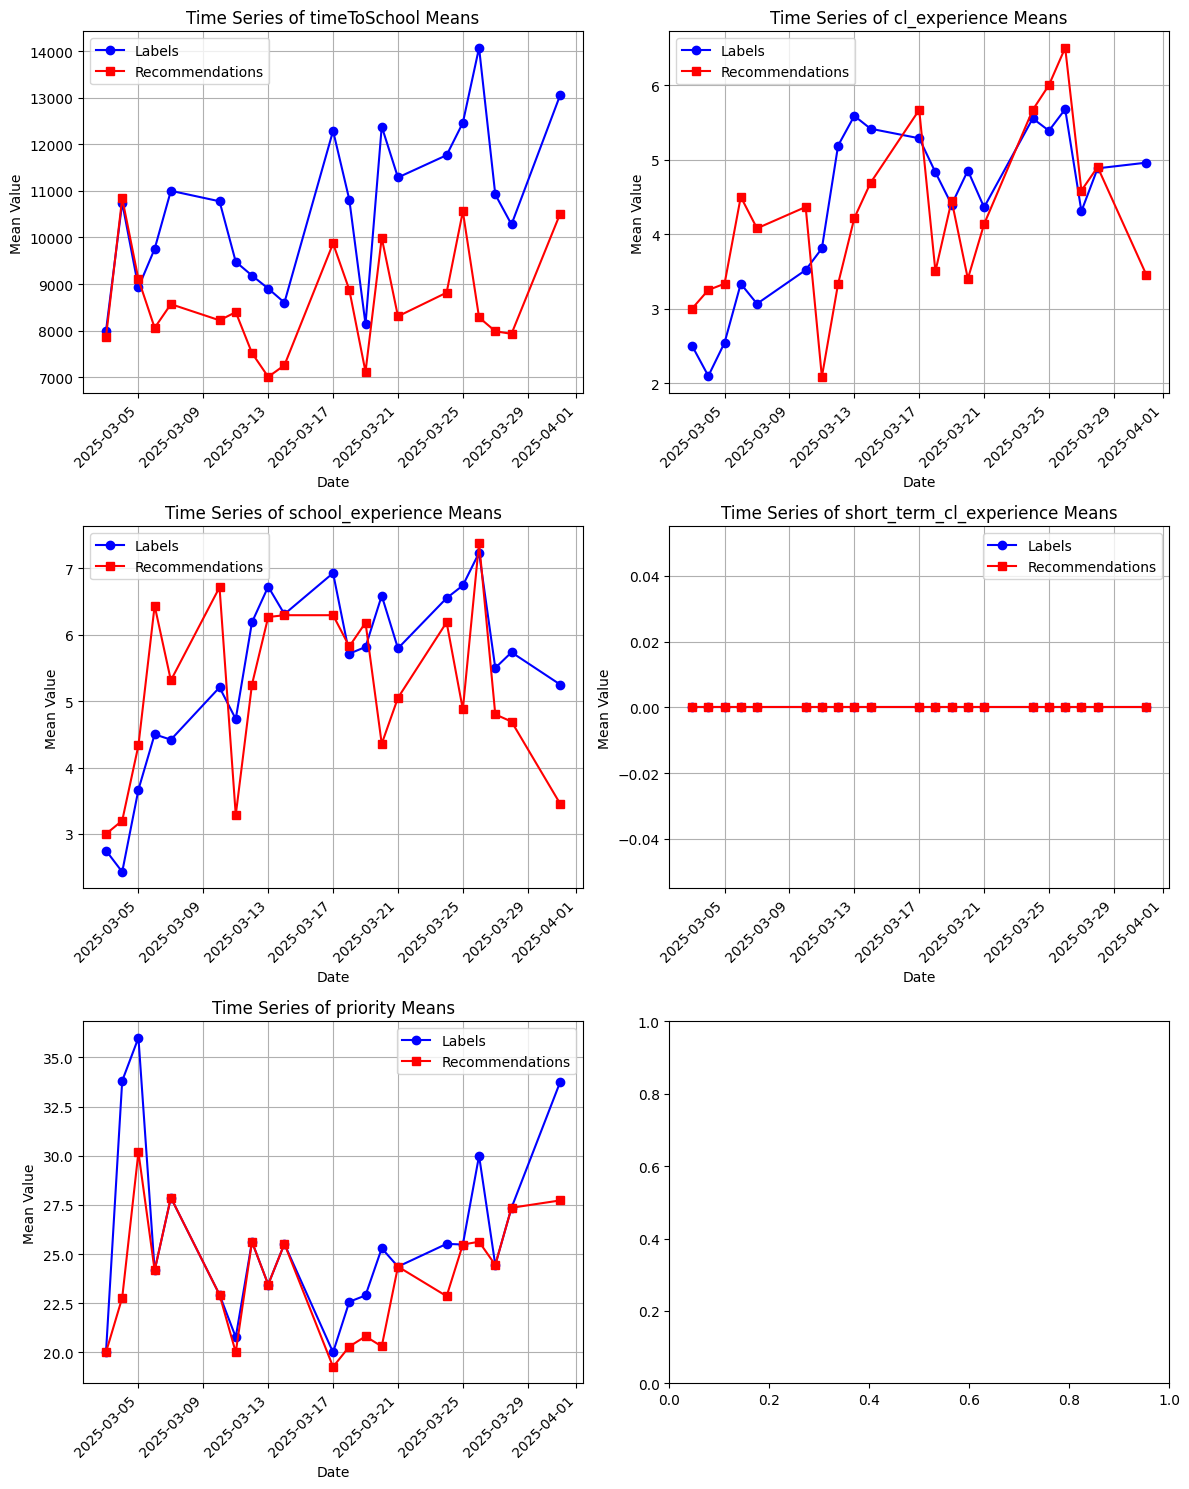

In [12]:
# print(my_dict)
# create_comparison_plots(my_dict)
create_time_series_plots(comparison)